**IMPORTS**

In [243]:
# OTHER #
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# SKLEARN #
from sklearn.linear_model import (
RidgeCV,
ElasticNetCV,
LassoCV
) 
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    r2_score
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier




**DATA PIPELINE CLASS**

In [244]:

data = pd.read_csv(r"..\data\student_portuguese_clean.csv")

#Pipeline class has methods that can prepare the data for further use

class Pipeline:
    
    def __init__(self, data, prediction_column):
        self.data = data
        self.prediction_column = prediction_column
    def getX(self):
        return self.data.drop(self.prediction_column, axis=1).to_numpy()
    def getData(self):
        return self.data
    def getY(self):
        return self.data[self.prediction_column].to_numpy()
    def getNumericalColumns(self):
        return self.data.select_dtypes(include=['float64', 'int64']).columns
    def getCorrelationMatrix(self):
        correlation_matrix = self.data[self.getNumericalColumns()].corr()
        
        plt.figure(figsize=(8, 8))
        sns.heatmap(correlation_matrix,
                    annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
        plt.title('Correlation Matrix of Numerical Columns')
        plt.show()
    def getDummies(self):
        #Represent non-numerical features numerically
        numerical_columns = self.getNumericalColumns()
        non_numerical_columns = self.data.columns.difference(numerical_columns)
    
        return pd.get_dummies(self.data, columns=non_numerical_columns, drop_first=True)
    def getCorrelationList(self):
        return self.getDummies().corr()["final_grade"].sort_values(ascending=False)
    

    



**X AND Y**

In [245]:
pipeline = Pipeline(data.drop("student_id", axis=1), "final_grade")

dummies = pipeline.getDummies()

X = dummies.drop("final_grade", axis = 1).to_numpy()
y = dummies["final_grade"].to_numpy()

#Standardizing input
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42, shuffle=True)



**REGRESSION**


            R2 Score
Lasso       0.935366
ElasticNet  0.926251
Ridge       0.910174


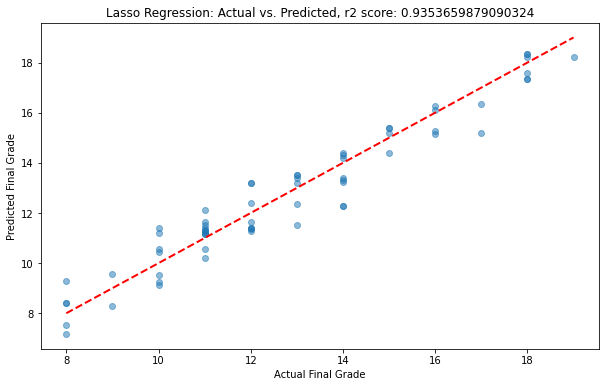

In [246]:

regression_models = {
    "Lasso" : LassoCV(cv=10).fit(X_train, y_train),
    "ElasticNet" : ElasticNetCV(cv=10).fit(X_train, y_train),
    "Ridge" : RidgeCV(cv=10).fit(X_train, y_train)
}


#A simple scatter plot of ytest and ypred, a good model should follow a diagonal line y=x
def makeScatter(ytest, ypred, r2score, modelname):
    plt.figure(figsize=(10, 6))
    plt.scatter(ytest, ypred, alpha=0.5)
    plt.plot([min(ytest), max(ytest)], [min(ytest), max(ytest)], '--', color='red', linewidth=2)  # Diagonal line
    plt.title(f'{modelname} Regression: Actual vs. Predicted, r2 score: {r2score}')
    plt.xlabel('Actual Final Grade')
    plt.ylabel('Predicted Final Grade')
    plt.show()


results = pd.DataFrame(columns=["R2 Score"], index=list(regression_models.keys()))
for modelname, model in regression_models.items():
    y_pred = model.predict(X_test)
    r2score = r2_score(y_test, y_pred)
    results.loc[modelname, :] = [r2score]
    

print(results)
# Convert the "R2 Score" column to numeric before using idxmax()
results["R2 Score"] = pd.to_numeric(results["R2 Score"])
best_model_name = results.idxmax()["R2 Score"]  # Get the model name with the highest R2 score
best_model = regression_models[best_model_name]  # Retrieve the best model from the dictionary
y_pred_best_model = best_model.predict(X_test)

makeScatter(y_test, y_pred_best_model, results.loc[best_model_name, "R2 Score"], best_model_name)

**BINARY CLASSIFICATION**


                           Test accuracy
DecisionTreeClassifier          0.923077
GradientBoostingClassifier      0.938462
KNeighborsClassifier            0.953846


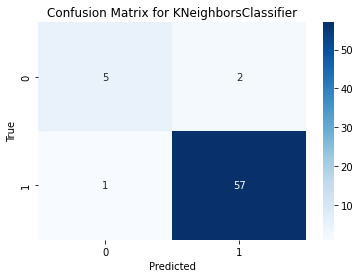

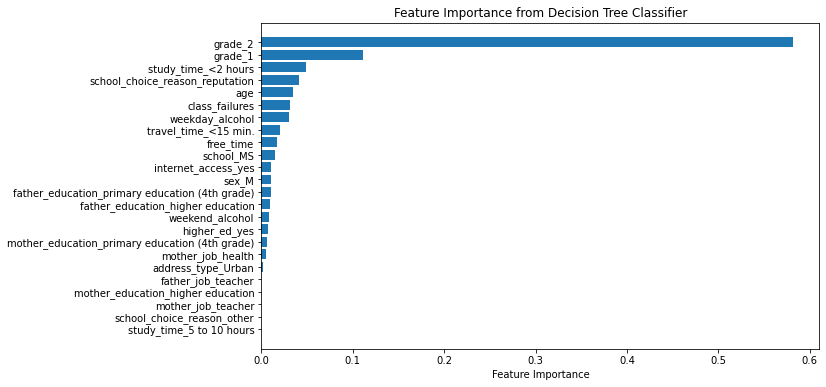

In [247]:
#Here the problem is reformulated to be solved like a binary classificaiton problem.
#Now we are not looking for a numerical prediction of the grade, rather a pass/fail prediction


#If correlation is less than abs(threshold) we discard the feature to reduce complexity/noise
threshold = 0.1

dummies_copy = dummies.copy()

for key, value in dummies_copy.corr()["final_grade"].iteritems():
  if abs(value) < threshold:
    dummies_copy.drop(columns= key, inplace=True)

#We transform y to a binary classification problem with a lambda function
#X greater than 10 means pass and less than is fail
X = dummies_copy.drop('final_grade',axis = 1)
y = dummies_copy['final_grade'].apply(lambda x: 'pass' if x >= 10 else 'fail')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)


classification_models = {
    "DecisionTreeClassifier" : DecisionTreeClassifier().fit(X_train, y_train),
    "GradientBoostingClassifier" : GradientBoostingClassifier().fit(X_train, y_train),
    "KNeighborsClassifier" : KNeighborsClassifier().fit(X_train, y_train)  
}

results = pd.DataFrame(columns=["Test accuracy"], index=list(classification_models.keys()))

for modelname, model in classification_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results.loc[modelname, :] = [accuracy]

print(results)
# Convert the "Test accuracy" column to numeric before using idxmax()
results["Test accuracy"] = pd.to_numeric(results["Test accuracy"])
best_model_name = results.idxmax()["Test accuracy"]  # Get the model name with the highest accuracy
best_model = classification_models[best_model_name]  # Retrieve the best model from the dictionary

y_pred_best_model = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best_model)

# Plot confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()


# Get feature importances
feature_importances = classification_models["DecisionTreeClassifier"].feature_importances_

# Match feature importances with feature names 
feature_importance_dict = dict(zip(X_train.columns, feature_importances))

# Sort feature importances in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

features, importances = zip(*sorted_feature_importances)

# Create a horizontal bar plot for feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), importances, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Decision Tree Classifier')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()








**ANN**

**MODEL #4**